# Constructing Zero Coupon Curve

The objective of this notebook is to understand how to obtain a ZC curve from data

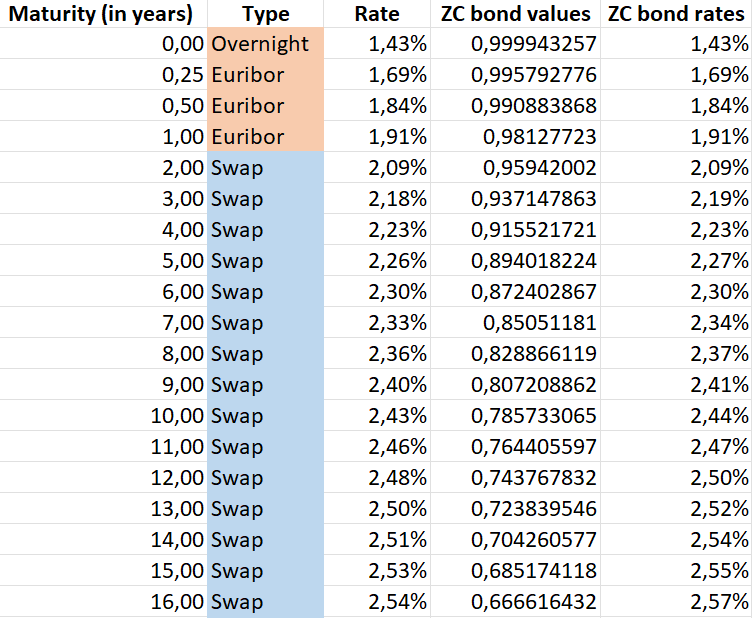

In [1]:
import numpy as np
import xlrd # import the library to read and extract data from Excel
from scipy.interpolate import interp1d
from math import exp, sqrt, log
import matplotlib.pyplot as plt
import pandas as pd

Since zero coupon instruments typically do not trade trade throughout the maturity spectrum, it is necessary to construct the zero coupon curve from underlying (traded) coupon bonds. Bloomberg and other providers of yield curve data perform such calculations by default; but it is naturally relevant to be able to reproduce such calculations. Firstly, as a means to double check and to gain an understanding of how such processes work, and secondly, and more importantly, by mastering the curve extraction methodology it is possible to create proprietary curves for yield curve segments that are not available from the licensed curve contributors, or as a means to create curves for combinations of curve segments that may be needed for ad-hoc analyses.</p><p>In principle, the required calculations are very simple, and of course, relies on the discounting of future cashflows. Define a universe of traded bonds that forms the foundation for the zero coupon yield curve calculations. These bonds should be activily traded and representative for the market segments under investigation. Let there $j$ bonds in the universe, and denote by $p$ the vector that collects the $j$ observed prices for these bonds, and by $C$ the matrix that collects their cashflows. Since the price of a bond is equal to the sum of the discounted future payments, the following holds: $p=C \cdot d$, where $d$ is the vector of discount factors. Zero coupon yields $y$ are related to discount factors as $y_j=d^{-1/j}-1$. Under the assumption that $C$ is invertible, the discount factors can then be found as: $d=C^{-1} \cdot p$, which then subsequiently can be converted in to zero coupn yield. The following examples illustrates this principle for the first four maturities, using constructed/hypothetical bond price data


In [2]:
# Load the Excel file
file_path = 'IRMarketCurve.xlsx'
data = pd.read_excel(file_path)

# Convert the DataFrame to a list of lists for further processing
IRCurve = data.values.tolist()

In [3]:
# Define the extractZCCurve function
def extractZCCurve(IRCurve):
    ZCrates = []
    ctsZCrates = []
    ZCvalues = []
    
    for i in range(4):  # The formula is valid for all rates with maturity < 1yr
        maturity = IRCurve[i+1][0]
        ZCrate = IRCurve[i+1][2]
        ZCvalue = 1 / (1 + maturity * ZCrate) # continuously compounded ZC
        ctsZCrate = -log(ZCvalue) / maturity # continuously compounded spot interest rate 1.10
        ZCrates.append([maturity, ZCrate])
        ctsZCrates.append([maturity, ctsZCrate])
        ZCvalues.append([maturity, ZCvalue])
    
    for i in range(4, len(IRCurve) - 1):  # For swaps with maturity >= 1yr
        maturity = IRCurve[i+1][0]
        ZCvalue = (1.0 - (1.0 - ZCvalues[i-1][1]) * (IRCurve[i+1][2] / IRCurve[i][2])) / (1 + IRCurve[i+1][2])
        ZCrate = ZCvalue ** (-1.0 / maturity) - 1.0 # annually compounded spot interest rate 1.10
        ctsZCrate = -log(ZCvalue) / maturity
        ZCrates.append([maturity, ZCrate])
        ctsZCrates.append([maturity, ctsZCrate])
        ZCvalues.append([maturity, ZCvalue])
    
    ZCrates = np.array(ZCrates)
    ctsZCrates = np.array(ctsZCrates)
    ZCvalues = np.array(ZCvalues)
    return ZCrates, ctsZCrates, ZCvalues

# Define the ZCCurve_inter function
def ZCCurve_inter(zccurve, T):
    y = interp1d(zccurve[:,0], zccurve[:,1], kind='linear', fill_value='extrapolate')
    return y(T)

# Define the P_t_T function
def P_t_T(T, y):
    return np.exp(-T * y)

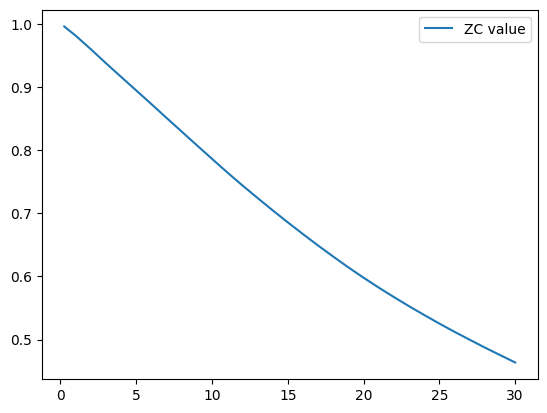

In [5]:
# plot zc value curve
ZCValues = extractZCCurve(IRCurve)[2]
plt.plot(ZCValues[:,0],ZCValues[:,1],label='ZC value')
plt.legend()
plt.show()

In [6]:
%store ZCValues

Stored 'ZCValues' (ndarray)
